(sec-text2circ)=

# From text to circuit

Thus far, our exploration of `lambeq` has been confined to sentence-level analysis. However, many compelling NLP tasks, such as discourse analysis, summarization, and {term}`coreference resolution`, inherently operate at the discourse level, requiring models to understand and process relationships and structures spanning across multiple sentences. To make this kind of tasks possible on a quantum computer, `lambeq` supports {term}`DisCoCirc` {cite:p}`coecke_2021a`, a framework of compositional models (still at the experimental stage) with the ability to encode entire paragraphs or documents into a quantum circuit. The generated quantum circuits capture the core semantic information of the provided text, and can be trained using `lambeq`'s {ref}`machine learning <sec-ml-lambeq>` features.

{download}`⬇️ Download code <../_code/discocirc-basics.ipynb>`

## Basics

DisCoCirc represents the entities found in the text as wires flowing from top to bottom in a {term}`string diagram`. These entities are modified by boxes or {term}`frames <frame>`, corresponding to higher-order linguistic constructions in the text. Let's see a simple example.

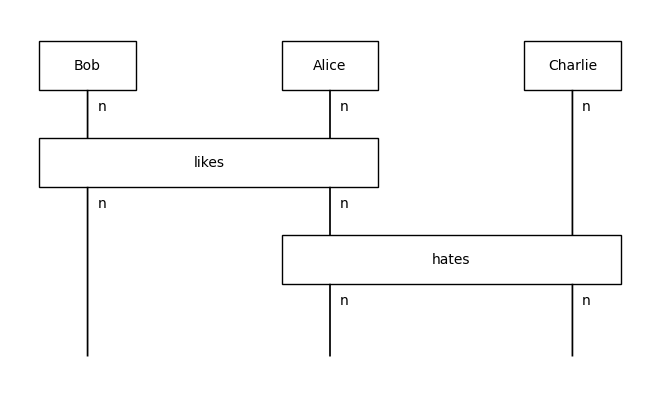

In [2]:
from lambeq.experimental.discocirc import DisCoCircReader

reader = DisCoCircReader()

text = "Bob likes Alice. Alice hates Charlie."
diagram = reader.text2circuit(text)
diagram.draw()

Our text has 3 entities, "Bob", "Alice", and "Charlie", and 2 boxes representing actions, "likes" and "hates", acting on and modifying these entities in the specific order. Note how the resulting diagram encapsulates the essential semantic content of the paragraph, abstracting away from its syntactic structure.

Let's move to a more interesting example.

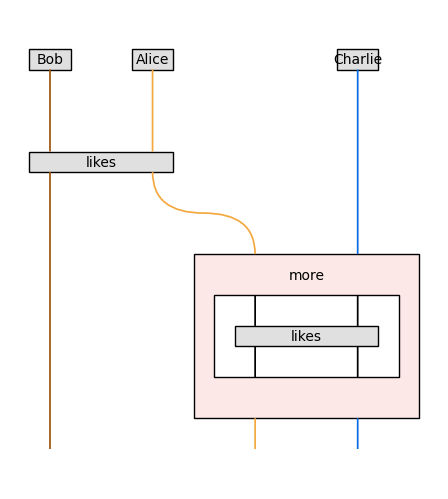

In [2]:
text = "Bob likes Alice. She likes Charlie more."
reader.text2circuit(text).draw()

Note that in this case, the DisCoCirc reader uses {term}`coreference resolution` to match the pronoun "she" in the second sentence with "Alice". Also, the generated circuit now contains a box nested into a higher-order {term}`frame`, representing the fact that the adverb "more" modifies the verb "likes" in the context of the interaction between "Alice" and "Charlie".

```{note}
When frames are present in a string diagram, `lambeq` uses a colour encoding for wires and frames to make the diagram more readable, as in the above image. By default, the colour of each frame indicates its "type", i.e. the number of nested boxes.
```

Sometimes, an entity can interact with more than one action, as in the following example:

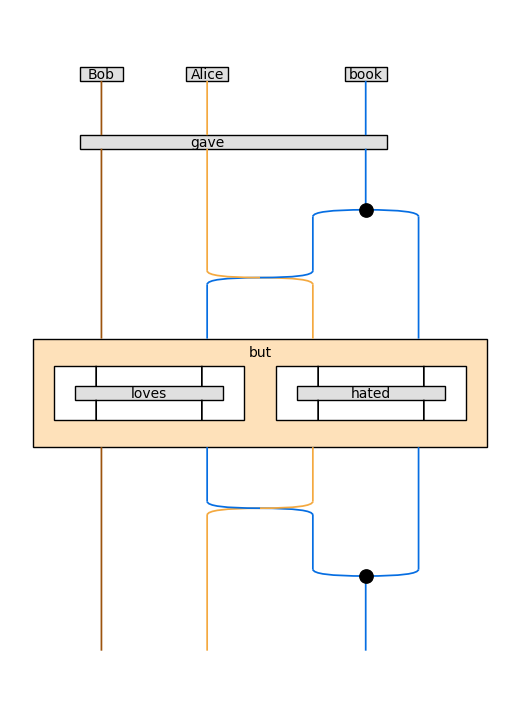

In [3]:
text = "Bob gave Alice a book. He loves it, but she hated it."
reader.text2circuit(text).draw(figsize=(5,7))

In the above, the book is loved by Bob, but at the same time hated by Alice. To allow this, the blue wire branches into two paths to interact with the separate actions and then recombines into a single wire to deliver the result. This branching and merging is achieved through {term}`spider` operations.

## Parsing longer texts

The {py:class}`~lambeq.experimental.discocirc.DisCoCircReader` is efficient and robust enough to parse really long texts, for example entire book chapters, into a single diagram. However, keep in mind that such a diagram can quickly become very dense, to the point it's difficult to read. In fact, as you can see below, even relatively short and simple texts can generate fairly complicated diagrams.

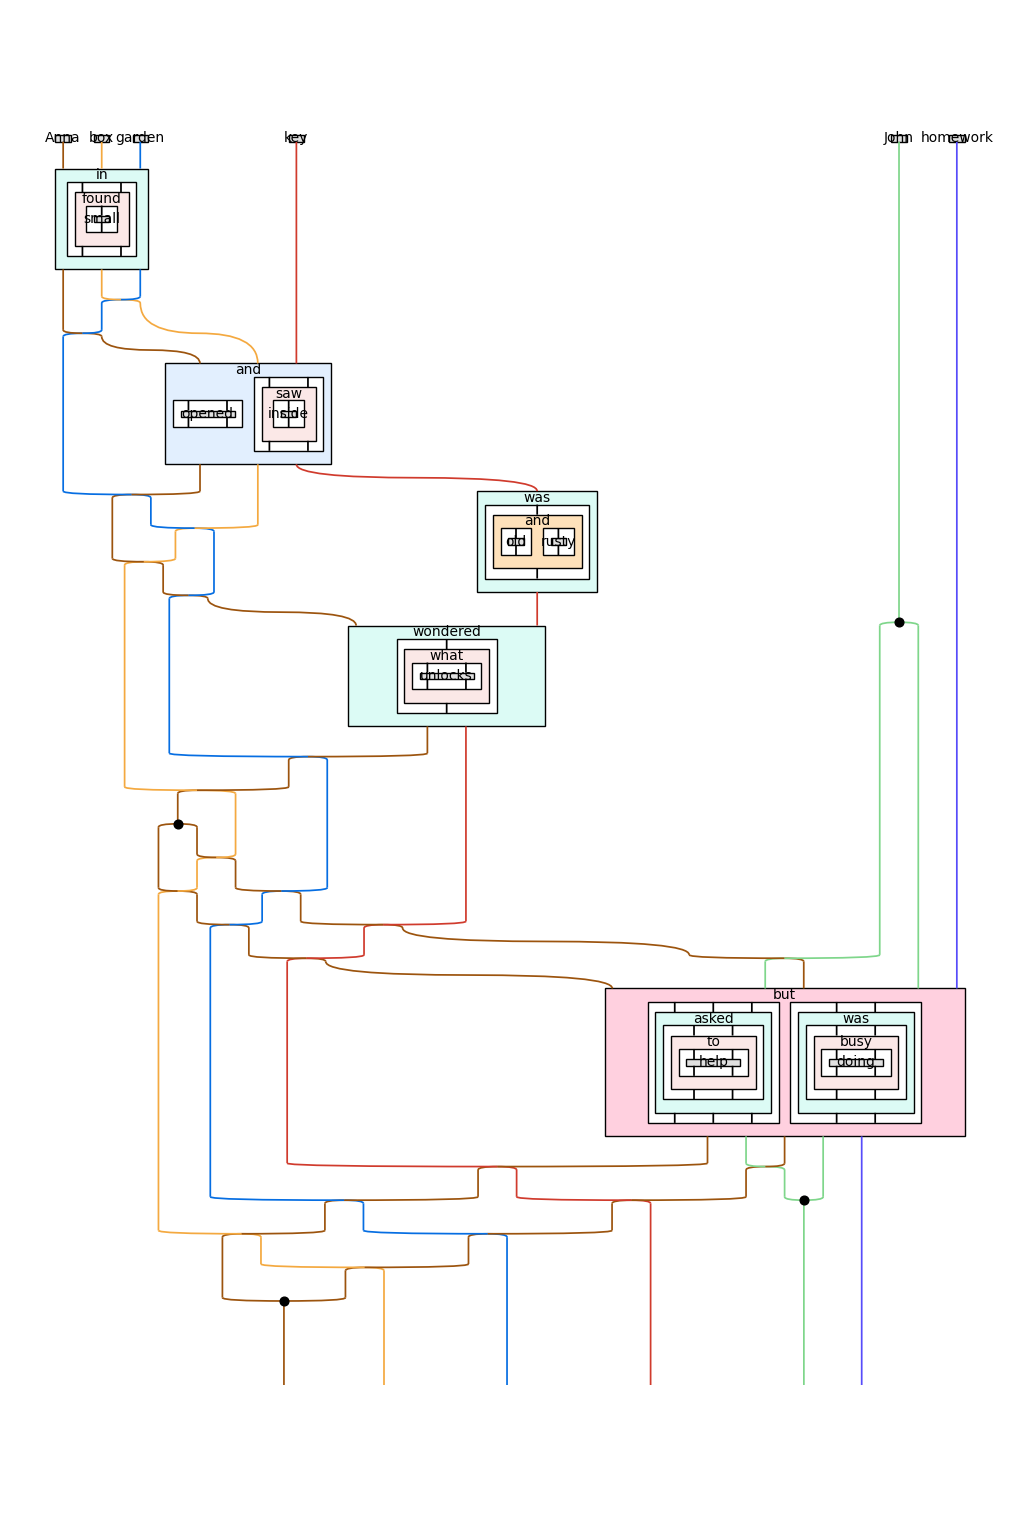

In [4]:
text = "Anna found a small box in the garden."\
       "She opened it and saw a key inside."\
       "The key was old and rusty."\
       "Anna wondered what it unlocks."\
       "She asked John to help her,"\
       "but he was busy doing homework."
reader.text2circuit(text).draw(figsize=(10,15))

```{note}
When trying to plot dense diagrams, increasing the size of the figure by using the `figsize` paramemeter in {py:meth}`~lambeq.backend.grammar.Diagram.draw` method can significantly improve the readability of the result.
```

## Simplifying the diagram

The {py:mod}`~lambeq.experimental.discocirc` package provides a few ways to abstact away some of the details of the text diagrams, which we introduce in the following sections.

### Rewrite rules

One way to avoid making your text diagrams excessively complex is to reduce the amount of frame nesting in expressions that involve large chains of modifiers. Check the following example:

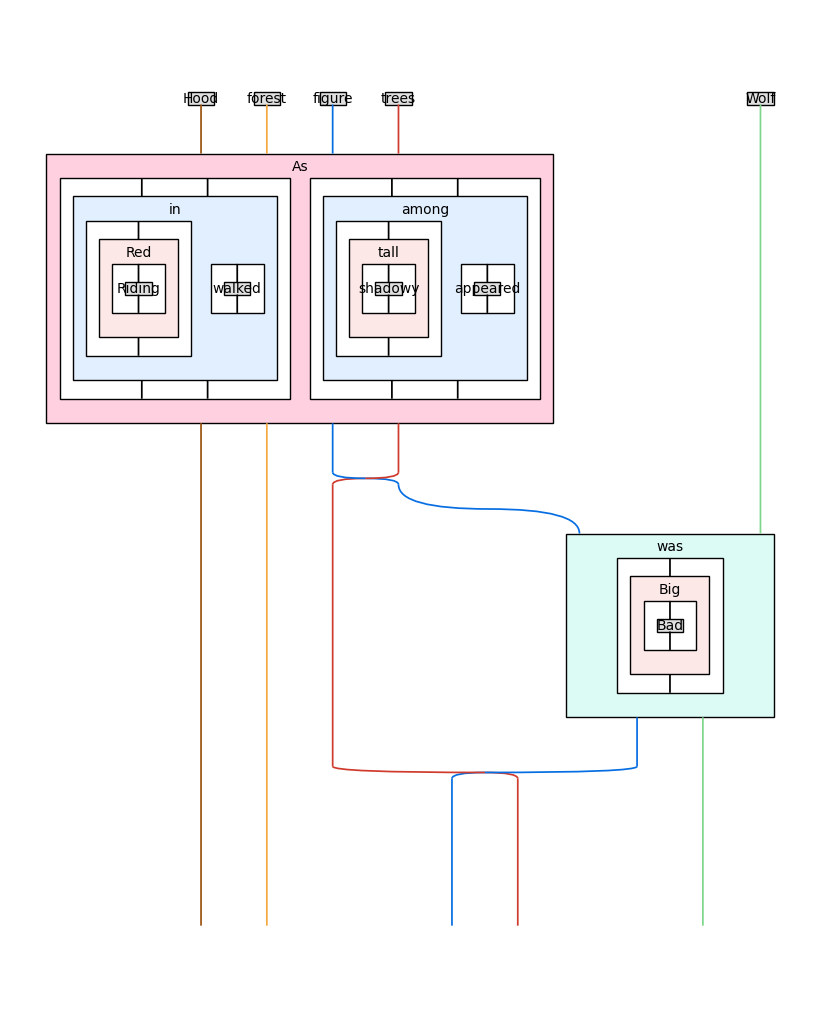

In [5]:
text =  "As Red Riding Hood walked in the forest, "\
        "a tall shadowy figure appeared among the trees. "\
        "It was the Big Bad Wolf."
reader.text2circuit(text).draw(figsize=(8,10))

Note that the entity "Red Riding Hood" has been represented simply as "hood", modified by the adjectives "red" and "riding" later in the timeline of the interactions in the text. Similarly, "big bad wolf" was analysed into a "wolf", modified by the higher-order boxes "big" and "bad". While this analysis makes linguistic sense, it has very limited use for cases like these.

{py:class}`~lambeq.experimental.discocirc.DisCoCircReader` provides the means to avoid using that level of detail through _rewrite rules_ that collapse long modification chains into a simpler entity. For example, in order to collapse all the noun-modification chains in the above diagram, you can use the `noun_modification` rule as below:

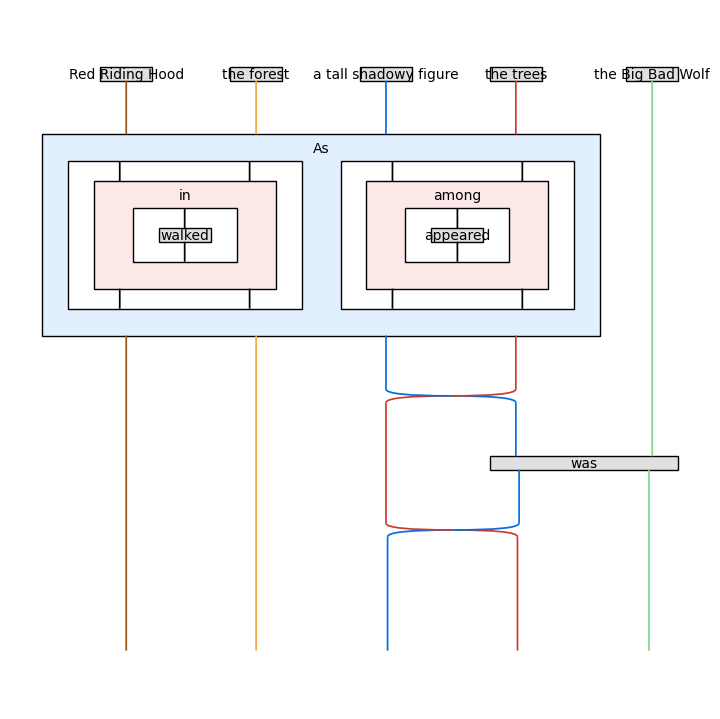

In [6]:
reader.text2circuit(text, rewrite_rules=['noun_modification']).draw(figsize=(7,7))

The resulting diagram is significantly simplified, while the entities on the top of the diagram make much more sense for the given story.

The table below includes all the pre-defined rewrite rules with short descriptions.

(tbl-tree-rewrites)=

| Rewrite rule                                 | Description                                                                    |
| -------------------------------------------- | ------------------------------------------------------------------------------ |
| `determiner`                                 | Joins determiners ("the", "an", "a") with the nouns they modify              |
| `auxiliary`                                  | Attempts to collapse auxiliaries ("do", "is" etc) with entities or actions they modify |
| `noun_modification`                          | Collapses all noun modification chains into a single entity |
| `verb_modification`                          | Attempts to collapse verb modification chains into a single action |
| `sentence_modification`                      | Attempts to collapse sentence modification chains |

```{note}
Users can create their own rewrite rules programmatically by using the class {py:class}`~lambeq.experimental.discocirc.TreeRewriteRule` in the {py:mod}`lambeq.experimental.discocirc` package.
```

```{tip}
To collapse _all_ possibile modification chains in a diagram, create an empty {py:class}`~lambeq.experimental.discocirc.TreeRewriteRule` and pass it to the `rewrite_rules` argument of the {py:meth}`~lambeq.experimental.discocirc.DisCoCircReader.text2circuit` method.
```

### Pruning infrequent nouns

Another way to simplify a DisCoCirc diagram is to ignore any entities that do not appear very frequently in the text. In the following example, note that "beagle" appears only once. We can ask from the reader to ignore any entities that do not occur above a specific threshold with the parameter `min_noun_freq`.

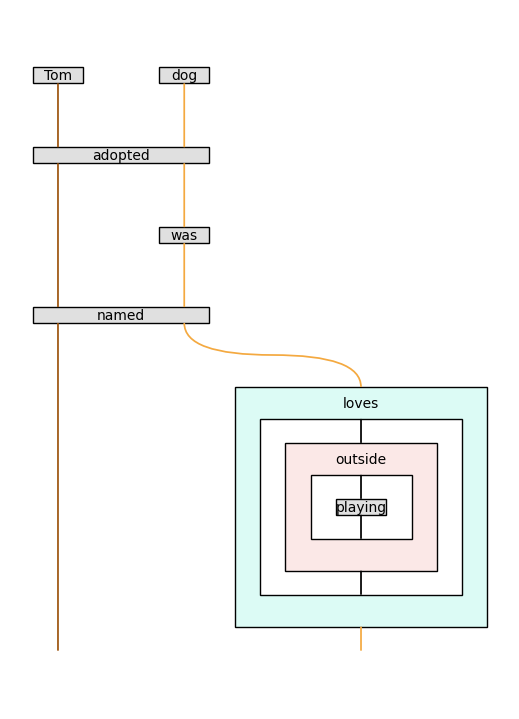

In [7]:
text = "Tom adopted a dog. The animal was a beagle. "\
       "He named it Max. The dog loves playing outside. "
diagram = reader.text2circuit(text, min_noun_freq=2)
diagram.draw(figsize=(5,7))



(sec-sandwich)=
## The "sandwich" functor

In a {term}`DisCoCirc` diagram, {term}`frames <frame>` can be seen as "quantum supermaps" that modify boxes. However, these supermaps do not correspond to unitary boxes and thus are not directly executable on a quantum computer. One way to convert a frame into a conventional structure of unitary boxes, is to insert trainable unitaries in the beginning and the end of the frame, as well as between each argument in it. This construction, known as the {term}`sandwich functor` {cite:p}`laakkonen_2024`, is inherently supported in {py:class}`~lambeq.experimental.discocirc.DisCoCircReader` class via the `sandwich` argument of the {py:meth}`~lambeq.experimental.discocirc.DisCoCircReader.text2circuit` method. Consider the following example:

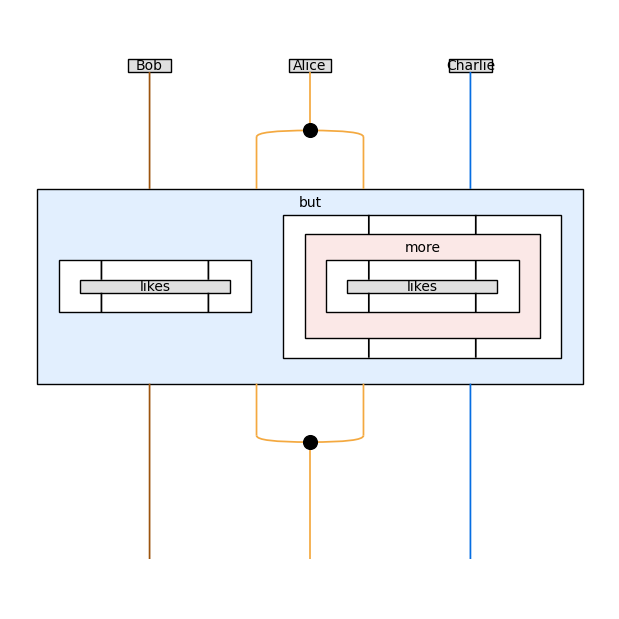

In [8]:
text = "Bob likes Alice, but she likes Charlie more."
reader.text2circuit(text).draw(figsize=(6,6))

Note that in this diagram, we get one frame with a single box in it ("more") and one frame with two boxes ("but"). Let's see how these frames will be converted to unitary box sequences by the {term}`sandwich functor`.

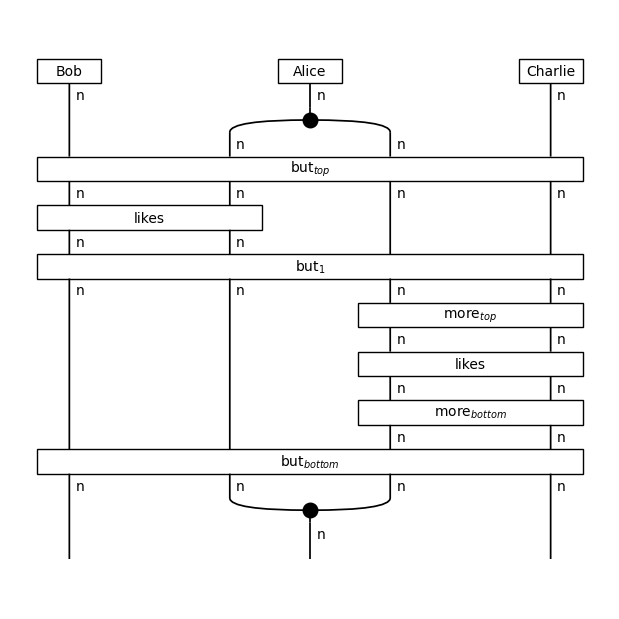

In [9]:
diagram = reader.text2circuit(text, sandwich=True)
diagram.draw(figsize=(6,6))

We'll focus first on frame "more", as it's the simpler case. You can see that it is now replaced by two unitary boxes that enwrap the "likes" box, one before and one after it - this is pretty much the idea behind the sandwich construction. In the slightly more complicated case of frame "but" which contains two boxes (actually, one box and one frame), note that these two boxes are separated by another special "separator" box (`but_1`). This applies to any number of boxes in the frame, i.e. for $n$ argument-boxes there will be $n-1$ separator-boxes in the final diagram.

## Applying an ansatz

A DisCoCirc diagram in the above form (i.e. with the sandwich construction applied), is a standard {term}`string diagram` that can be converted into a {term}`quantum circuit` by the application of any ``lambeq`` {term}`ansatz <ansatz (plural: ansätze)>`.

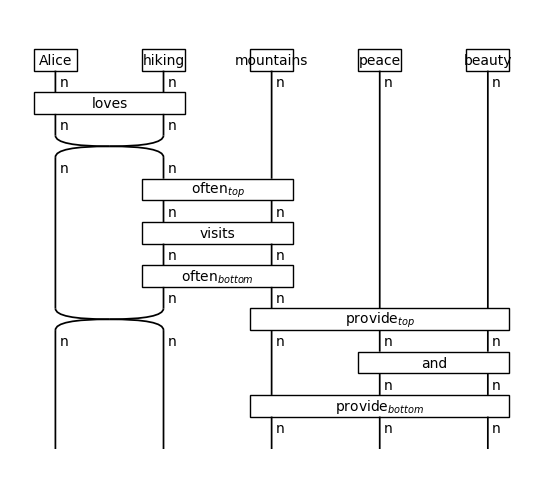

In [10]:
from lambeq import Sim4Ansatz, AtomicType

text = "Alice loves hiking. She often visits mountains. They provide peace and beauty."
diagram = reader.text2circuit(text, sandwich=True)
diagram.draw()

We'll use the {py:class}`~lambeq.ansatz.Sim4Ansatz` to convert the above diagram into a circuit.

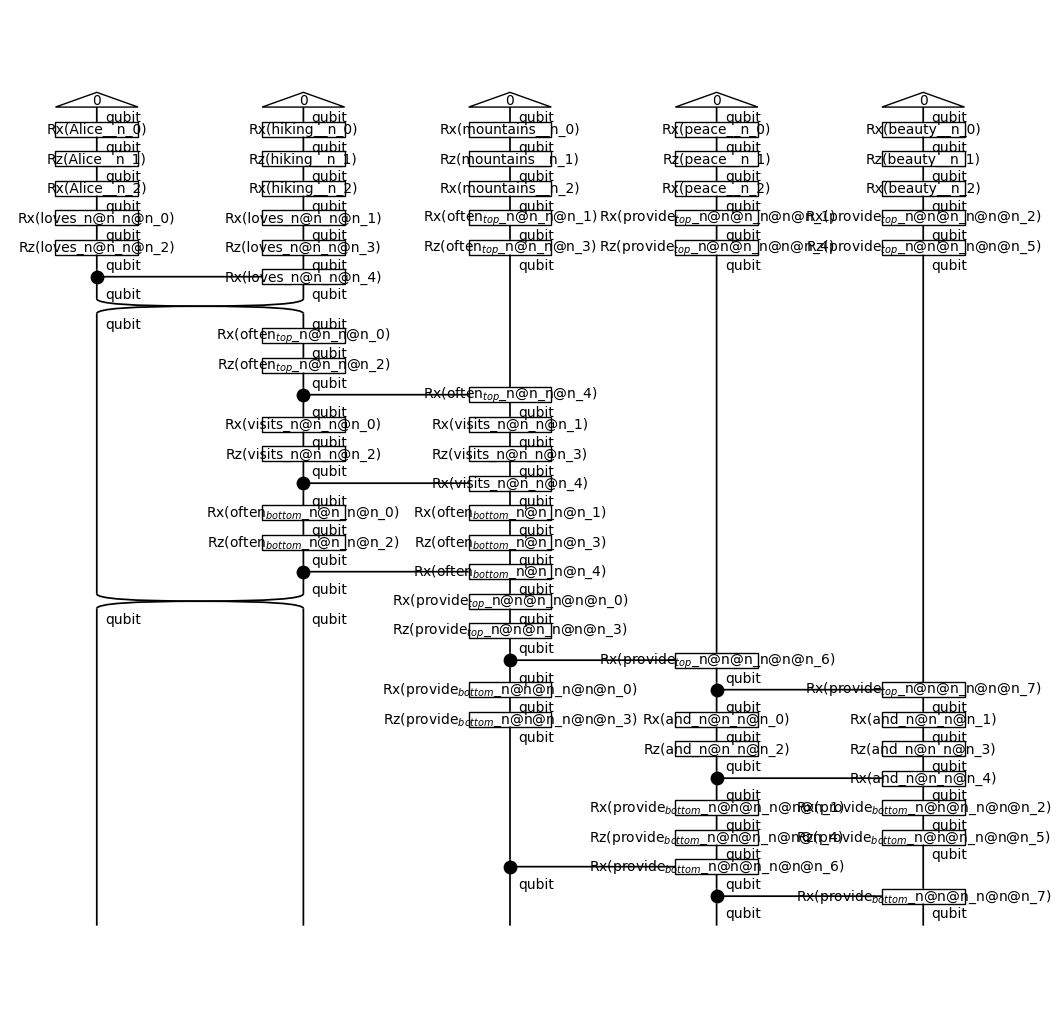

In [11]:
ansatz = Sim4Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1)
circuit = ansatz(diagram)
circuit.draw(figsize=(10,10))

You are now ready to train your text circuits with any ``lambeq`` model/trainer. See the {ref}`DisCoCirc training tutorial <sec-discocirc_training>` for more details.

```{rubric} See also:
```

- Check {cite:p}`duneau_2024` for some experimental results based on the {term}`DisCoCirc` model.
- {ref}`sec-discocirc_training`